In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import mne
from pqdm.processes import pqdm

import stat_func
import utilities

mne.set_log_level(verbose='WARNING')

N_JOBS = 7  # Should match the number of your (high-performance) CPU cores

%matplotlib inline

## Let's look at one file – cleaned epochs

In [31]:
subject = "04"
meg_subject_dir = Path(f'lb_analysis_sparse/import_metadata/sub-{subject}/meg/')
epochs_fname = meg_subject_dir / f"sub-{subject}_task-sparse_metadata_proc-clean_epo.fif"
epochs = mne.read_epochs(epochs_fname)
epochs

In [3]:
epochs.event_id

{'Node1/Tone4/Comm1/Transition2': 1,
 'Node1/Tone4/Comm1/Transition5': 3,
 'Node10/Tone7/Comm2/Transition1': 5,
 'Node10/Tone7/Comm2/Transition2': 6,
 'Node11/Tone8/Comm2/Transition1': 9,
 'Node11/Tone8/Comm2/Transition2': 10,
 'Node12/Tone3/Comm2/Transition2': 13,
 'Node12/Tone3/Comm2/Transition5': 15,
 'Node2/Tone9/Comm1/Transition1': 17,
 'Node2/Tone9/Comm1/Transition2': 18,
 'Node3/Tone2/Comm1/Transition1': 21,
 'Node3/Tone2/Comm1/Transition2': 22,
 'Node4/Tone6/Comm1/Transition1': 25,
 'Node4/Tone6/Comm1/Transition2': 26,
 'Node5/Tone5/Comm1/Transition1': 29,
 'Node5/Tone5/Comm1/Transition2': 30,
 'Node6/Tone11/Comm1/Transition2': 33,
 'Node6/Tone11/Comm1/Transition5': 35,
 'Node7/Tone10/Comm2/Transition2': 38,
 'Node7/Tone10/Comm2/Transition5': 40,
 'Node8/Tone12/Comm2/Transition1': 42,
 'Node8/Tone12/Comm2/Transition2': 43,
 'Node9/Tone1/Comm2/Transition1': 46,
 'Node9/Tone1/Comm2/Transition2': 47,
 'Node1/Tone4/Comm1/Transition4': 2,
 'Node1/Tone4/Comm1/Transition7': 4,
 'Node1

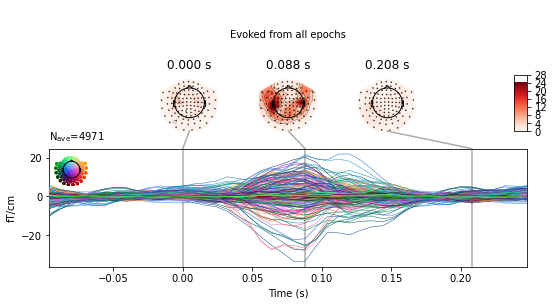

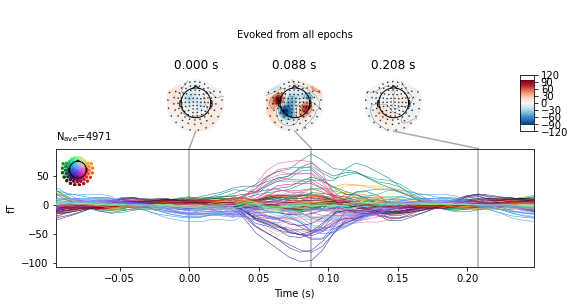

In [5]:
evoked = epochs.average()
evoked.plot_joint(title='Evoked from all epochs');

## A very brief introduction to epochs metadata

In [50]:
epochs.metadata

,event_name,Node,Tone,Comm,Transition,numTrial,numBlock,numTrialinBlock,Cond
0,Node10/Tone7/Comm2/Transition1,10,7,2,1,1,0,1,1
1,Node11/Tone8/Comm2/Transition1,11,8,2,1,2,0,2,1
2,Node12/Tone3/Comm2/Transition2,12,3,2,2,3,0,3,1
3,Node11/Tone8/Comm2/Transition2,11,8,2,2,4,0,4,1
5,Node9/Tone1/Comm2/Transition2,9,1,2,2,6,0,6,1
...,...,...,...,...,...,...,...,...,...
6715,Node5/Tone5/Comm1/Transition1,5,5,1,1,6716,6,956,1
6716,Node6/Tone11/Comm1/Transition2,6,11,1,2,6717,6,957,1
6717,Node5/Tone5/Comm1/Transition2,5,5,1,2,6718,6,958,1
6718,Node3/Tone2/Comm1/Transition3,3,2,1,3,6719,6,959,2


In [62]:
epochs.metadata['Cond']

0       1
1       1
2       1
3       1
5       1
       ..
6715    1
6716    1
6717    1
6718    2
6719    1
Name: Cond, Length: 4971, dtype: int64

In [63]:
epochs.metadata['Cond'].unique()

array([1, 3, 2, 4])

In [52]:
epochs.metadata.to_clipboard(index=False)

In [65]:
epochs['Cond == 3']

Number of events,378
Events,Node1/Tone4/Comm1/Transition5: 96Node12/Tone3/Comm2/Transition5: 95Node6/Tone11/Comm1/Transition5: 88Node7/Tone10/Comm2/Transition5: 99
Time range,-0.096 – 0.248 sec
Baseline,-0.096 – 0.000 sec


In [85]:
epochs['Cond == 3 or Cond == 4']

Number of events,530
Events,Node1/Tone4/Comm1/Transition5: 96Node1/Tone4/Comm1/Transition7: 14Node10/Tone7/Comm2/Transition7: 9Node11/Tone8/Comm2/Transition7: 11Node12/Tone3/Comm2/Transition5: 95Node12/Tone3/Comm2/Transition7: 13Node2/Tone9/Comm1/Transition7: 12Node3/Tone2/Comm1/Transition6: 15Node4/Tone6/Comm1/Transition6: 12Node5/Tone5/Comm1/Transition7: 14Node6/Tone11/Comm1/Transition5: 88Node6/Tone11/Comm1/Transition7: 9Node7/Tone10/Comm2/Transition5: 99Node7/Tone10/Comm2/Transition7: 10Node8/Tone12/Comm2/Transition6: 14Node9/Tone1/Comm2/Transition6: 19
Time range,-0.096 – 0.248 sec
Baseline,-0.096 – 0.000 sec


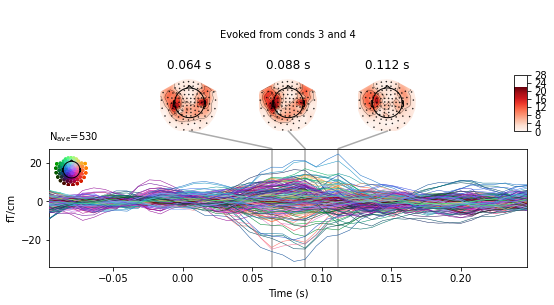

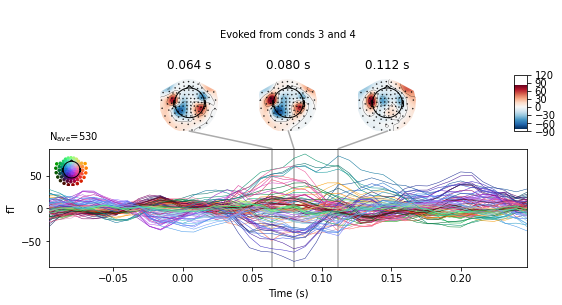

In [7]:
epochs['Cond == 3 or Cond == 4'].average().plot_joint(title='Evoked from conds 3 and 4');

## Compute evoked contrast for one subject

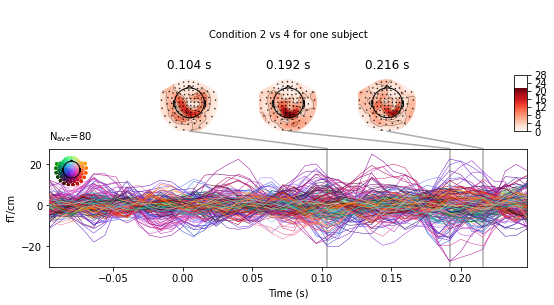

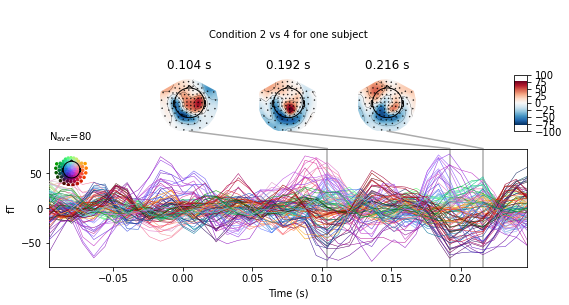

In [8]:
evoked_2 = epochs['Cond == 2'].average()
evoked_4 = epochs['Cond == 4'].average()

evoked_2_vs_4 = mne.combine_evoked(
    [evoked_2, evoked_4],
    weights=[1, -1]
)
evoked_2_vs_4.plot_joint(title='Condition 2 vs 4 for one subject');


## Compute evoked contrasts for all subjects

### Function to read epochs

In [16]:
def read_cleaned_epochs(subject):
    # Import epochs
    meg_subject_dir = Path(f'lb_analysis_sparse/import_metadata/sub-{subject}/meg/')
    filename = f'sub-{subject}_task-sparse_metadata_proc-clean_epo.fif'
    epochs_path = meg_subject_dir / filename

    epochs = mne.read_epochs(epochs_path)
    return epochs

### Let's look at differences between conditions at the group level

In [22]:
subjects = [
    '04', '06','07','08','09', '13','14','15','16','18','19',
    '20','21','22','23','24','25','26','27','28','29','30','32'
]

contrast = ['Cond == 2', 'Cond == 4']

all_evokeds = {
    contrast[0]: [],
    contrast[1]: []
}

for subject in subjects:
    print(f'Processing subject: {subject}')
    # Read epochs
    epochs = read_cleaned_epochs(subject)

    evoked_0 = epochs[contrast[0]].average()
    evoked_1 = epochs[contrast[1]].average()

    all_evokeds[contrast[0]].append(evoked_0)
    all_evokeds[contrast[1]].append(evoked_1)


Processing subject: 04
Processing subject: 06
Processing subject: 07
Processing subject: 08
Processing subject: 09
Processing subject: 13
Processing subject: 14
Processing subject: 15
Processing subject: 16
Processing subject: 18
Processing subject: 19
Processing subject: 20
Processing subject: 21
Processing subject: 22
Processing subject: 23
Processing subject: 24
Processing subject: 25
Processing subject: 26
Processing subject: 27
Processing subject: 28
Processing subject: 29
Processing subject: 30
Processing subject: 32
{'Cond == 2': [<Evoked | '0.08 × Node1/Tone4/Comm1/Transition4 + 0.10 × Node10/Tone7/Comm2/Transition4 + 0.07 × Node11/Tone8/Comm2/Transition3 + 0.06 × Node12/Tone3/Comm2/Transition4 + 0.07 × Node2/Tone9/Comm1/Transition4 + 0.10 × Node3/Tone2/Comm1/Transition3 + 0.08 × Node4/Tone6/Comm1/Transition4 + 0.11 × Node5/Tone5/Comm1/Transition3 + 0.09 × Node6/Tone11/Comm1/Transition4 + 0.09 × Node7/Tone10/Comm2/Transition4 + 0.07 × Node8/Tone12/Comm2/Transition4 + 0.09 × Nod

#### Visualize GFP / RMS for both conditions

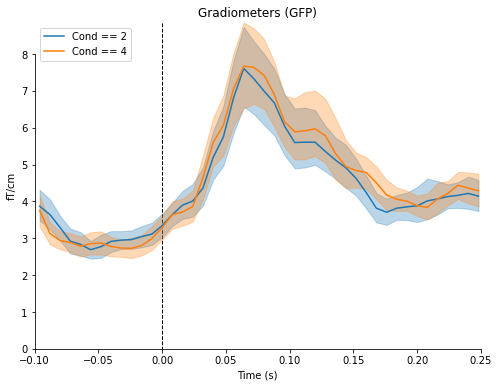

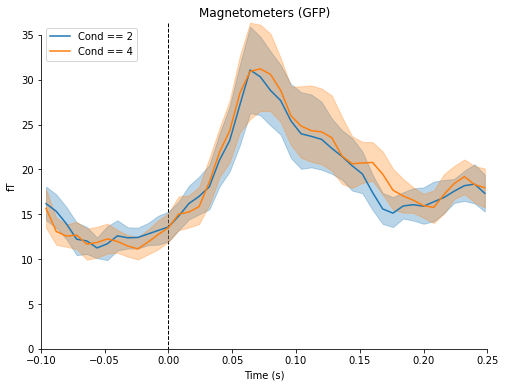

[<Figure size 576x432 with 1 Axes>, <Figure size 576x432 with 1 Axes>]

In [25]:
mne.viz.plot_compare_evokeds(all_evokeds)

#### Visualize just a single sensor

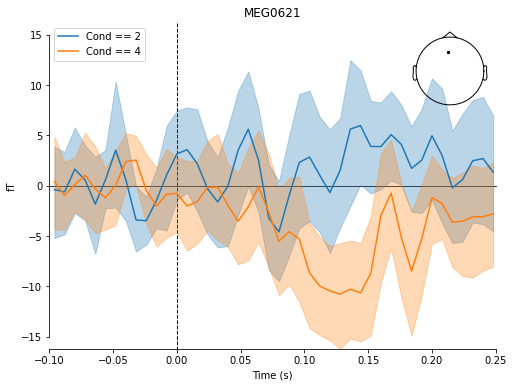

[<Figure size 576x432 with 2 Axes>]

In [29]:
mne.viz.plot_compare_evokeds(all_evokeds, picks=['MEG0621'])

### Function to calculate the evoked contrast

In [32]:
def compute_evoked_contrast(subject):
    # Read epochs
    epochs = read_cleaned_epochs(subject)

    # Compute evokeds
    evokeds = [
        epochs[contrast[0]].average(),
        epochs[contrast[1]].average()
    ]

    # Contrast the evokeds
    evoked_contrast = mne.combine_evoked(evokeds, weights=[1, -1])

    return evoked_contrast

### Run this for all subjects now!

In [18]:
subjects = [
    '04', '06','07','08','09', '13','14','15','16','18','19',
    '20','21','22','23','24','25','26','27','28','29','30','32'
]

evoked_contrasts_all_subjects= pqdm(
    subjects,
    function=compute_evoked_contrast,
    n_jobs=1
)

print(f'Calculated {len(evoked_contrasts_all_subjects)} contrasts!')

  0%|          | 0/11 [00:00<?, ?it/s]

Calculated 11 contrasts!


### Calculate grand average contrast

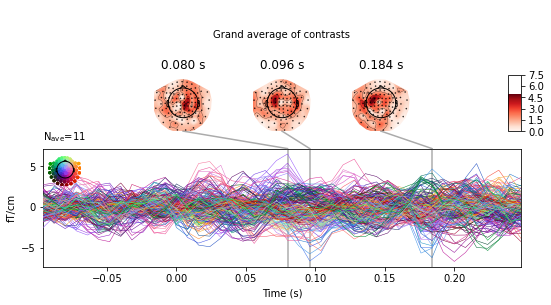

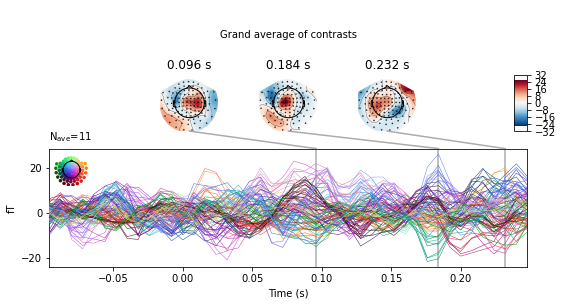

In [34]:
evoked_contrast_grand_average = mne.grand_average(evoked_contrasts_all_subjects)
evoked_contrast_grand_average.plot_joint(title='Grand average of contrasts');